# First Kaggle competition - Titanic: Machine Learning from Disaster

In [550]:
import math as m
import numpy as np
import pandas as pd
from sklearn import linear_model
from sklearn import preprocessing
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier
from matplotlib import pyplot as pp
pp.rcParams['figure.figsize'] = [10, 10]

def analyzeColumns(df):
    numeric_columns = df.select_dtypes(include=[np.number]).columns.tolist()
    res = pd.DataFrame()
    for col in df:
        col_res = pd.Series()
        if col in numeric_columns:
            col_res["minimum"] = df[col].min()
            col_res["maximum"] = df[col].max()
            col_res["mean"] = df[col].mean()
            col_res["stddev"] = df[col].std()
            col_res["nans"] = df[col].isna().sum()
            col_res["unique"] = df[col].nunique()
        else:
            col_res["nans"] = df[col].isna().sum()
            col_res["unique"] = df[col].nunique()
        res[col] = col_res
    return pd.DataFrame(res)

## Description of fields:


    
| Survival 	| Did passenger survive          	|
|----------	|--------------------------------	|
| PClass   	| Ticket class                   	|
| Name   	| Passenger's name                   	|
| Sex      	| Sex                            	|
| Age      	| Age in years                   	|
| SibSp    	| # of siblings / spouses aboard 	|
| Parch    	| # of parents / children aboard 	|
| Ticket   	| Ticket number                  	|
| Fare     	| Passenger fare                 	|
| Cabin    	| Cabin number                   	|
| Embarked 	| Port of embarkation            	|




## Loading and overview

In [551]:
train_df = pd.read_csv("train.csv", index_col="PassengerId")
test_df = pd.read_csv("test.csv", index_col="PassengerId")

In [552]:
len(train_df), len(test_df)

(891, 418)

In [553]:
train_df.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [554]:
train_analysis = analyzeColumns(train_df)
train_analysis

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
minimum,0.000000,1.000000,NaN,NaN,0.420000,0.000000,0.000000,NaN,0.000000,NaN,NaN
maximum,1.000000,3.000000,NaN,NaN,80.000000,8.000000,6.000000,NaN,512.329200,NaN,NaN
mean,0.383838,2.308642,NaN,NaN,29.699118,0.523008,0.381594,NaN,32.204208,NaN,NaN
stddev,0.486592,0.836071,NaN,NaN,14.526497,1.102743,0.806057,NaN,49.693429,NaN,NaN
nans,0.000000,0.000000,0.0,0.0,177.000000,0.000000,0.000000,0.0,0.000000,687.0,2.0
unique,2.000000,3.000000,891.0,2.0,88.000000,7.000000,7.000000,681.0,248.000000,147.0,3.0


,Survived
Survived,
0,549
1,342


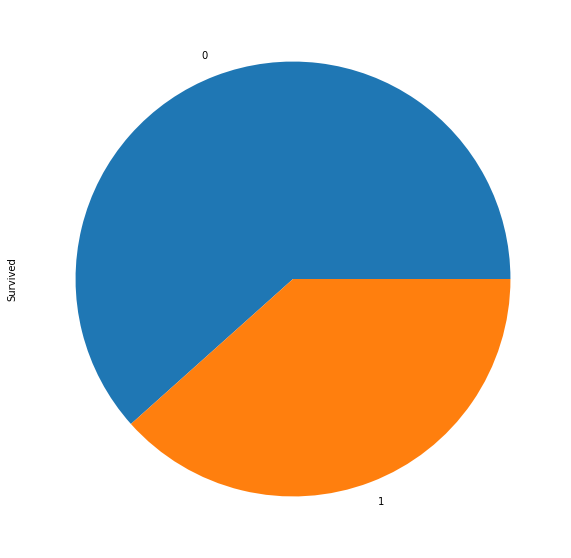

In [555]:
train_df.groupby("Survived").agg({"Survived":'count'})["Survived"].plot.pie()
train_df.groupby(["Survived"]).agg({'Survived':'count'})

## Training data preparation

In [556]:
drop_cols = ["Ticket", "Cabin"]
train_df.drop(drop_cols, axis=1, inplace=True)

train_df.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked
PassengerId,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,7.2500,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,71.2833,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,7.9250,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,53.1000,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,8.0500,S


### Features: "Pclass" and "Fare"

Survived      
            mean count
Pclass                
1       0.629630   216
2       0.472826   184
3       0.242363   491

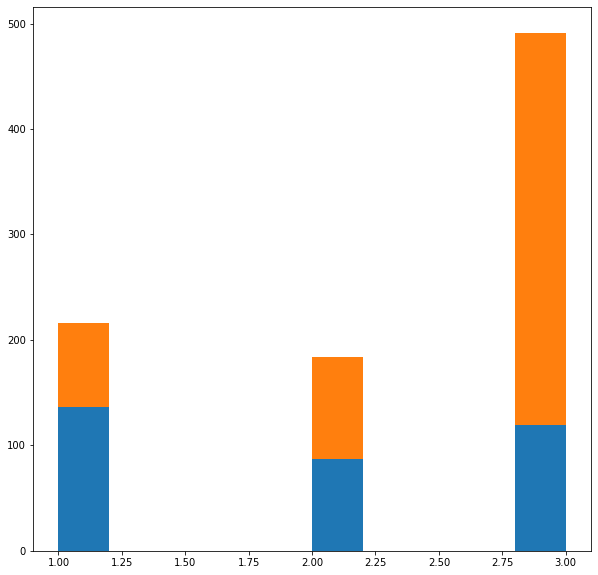

In [557]:
notsurvived, survived = train_df[train_df["Survived"] == 0], train_df[train_df["Survived"] == 1]
b = pp.hist([survived["Pclass"], notsurvived["Pclass"]], stacked=True)
train_df.groupby(["Pclass"]).agg({'Survived':[np.mean, 'count']})

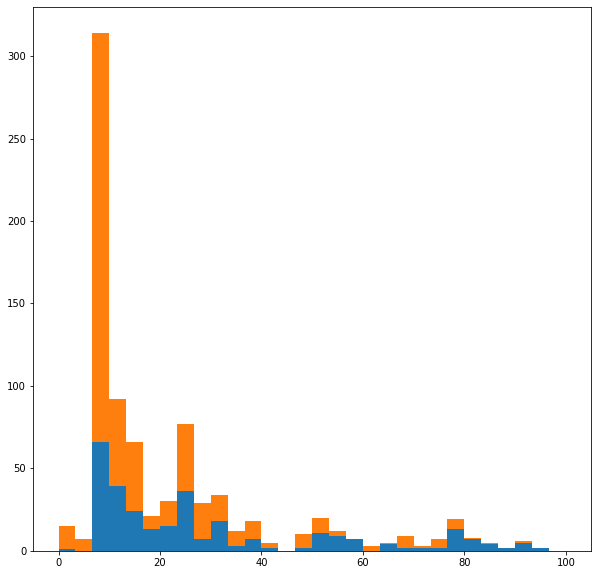

In [558]:
b = pp.hist([survived["Fare"], notsurvived["Fare"]], bins=30, range=(0, 100), stacked=True)

In [559]:
bucketFare = lambda x: int(m.floor(x**(1.0/5.0)))
def binFare(df):
    df["Fare_bin"] = df["Fare"].apply(lambda x: bucketFare(x))
    
binFare(train_df)

In [560]:
train_df.groupby(["Fare_bin"]).agg({'Survived':[np.mean, 'count']})

Survived      
              mean count
Fare_bin                
0         0.066667    15
1         0.323308   665
2         0.590000   200
3         0.727273    11

In [561]:
# Semi-strong negative correlation... Expected... Should probably consider using one or the other.
np.corrcoef(np.array(train_df["Pclass"]), np.array(train_df["Fare_bin"]))

array([[ 1.        , -0.56010871],
       [-0.56010871,  1.        ]])

### Features: "Age" , "Name" and "Sex"

Age has 177 out of 891 missing values, is there a good approx we can get from existing data?

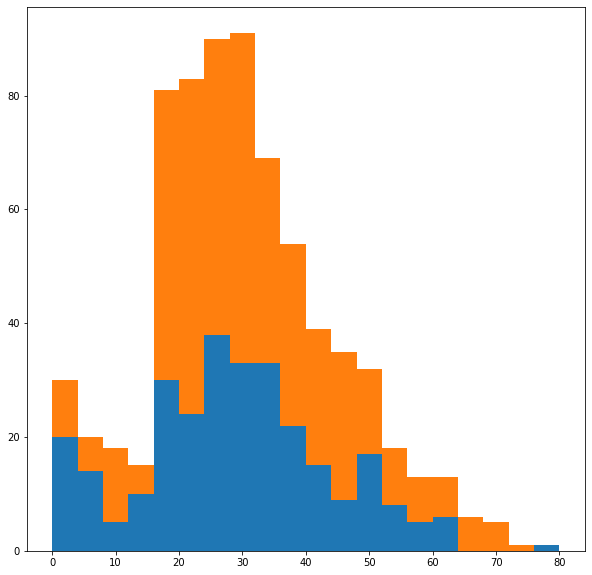

In [562]:
b = pp.hist([survived["Age"], notsurvived["Age"]], bins=20, range=(0, 80), stacked=True)

In [563]:
from collections import Counter

a = Counter()
for arr in train_df["Name"].apply(lambda x: x.split(" ")):
    for name in arr:
        a[name] += 1

for title, num in a.most_common(50):
    print("{:10} {:3}".format(title, num))


Mr.        517
Miss.      182
Mrs.       125
William     62
John        44
Master.     40
Henry       33
James       24
Charles     23
George      22
Thomas      21
Edward      18
Joseph      16
Johan       15
Frederick   15
Mary        13
Richard     13
Samuel      13
Arthur      13
Alfred      12
Anna        11
Jr          10
Elizabeth    9
Andersson,   9
Alexander    9
Ernest       9
Robert       9
Karl         9
Peter        9
J            8
Leonard      8
H            8
Margaret     8
Albert       8
Martin       8
Victor       8
Maria        7
Sage,        7
Dr.          7
de           7
Johnson,     6
E            6
Panula,      6
(Elizabeth   6
Goodwin,     6
Skoog,       6
Francis      6
Helen        6
Frank        6
Sofia        6


In [564]:
def assignTitle(x):
    titles = ["Mr.", "Miss.", "Mrs.",  "Master.", "Dr."]
    intersec  = list(set(x).intersection(set(titles)))
    if len(intersec) == 0:
        return "Other"
    else:
        return intersec[0]
    
train_df["Title"] = train_df["Name"].apply(lambda x: assignTitle(x.split(" ")))
ages = train_df.groupby(["Title"]).agg({'Age':[np.mean, 'count']})

ages

Age      
              mean count
Title                   
Dr.      42.000000     6
Master.   4.574167    36
Miss.    21.773973   146
Mr.      32.368090   398
Mrs.     35.898148   108
Other    42.500000    20

In [565]:
# bucketAge = lambda x: int(m.floor(x**(1.0/3.0)))

def binAge(df):
    
    def fillAge(x):
        if m.isnan(x["Age"]):
            x["Age"] = int(m.floor(ages.loc[x["Title"]].values[0]))
        return x
    
    df = df.apply(lambda x: fillAge(x), axis=1)     
    # df["Age_bin"] = df["Age"].apply(lambda x: bucketAge(x))
    df["Age_bin"] = pd.cut(df["Age"], [0, 6, 18, 100], labels=[0, 1, 2], include_lowest=True)
    return df

train_df = binAge(train_df)

train_df.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked,Fare_bin,Title,Age_bin
PassengerId,,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,7.2500,S,1,Mr.,2
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,71.2833,C,2,Mrs.,2
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,7.9250,S,1,Miss.,2
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,53.1000,S,2,Mrs.,2
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,8.0500,S,1,Mr.,2


In [566]:
train_df.groupby(["Age_bin"]).agg({'Survived':[np.mean, 'count']})

Survived      
             mean count
Age_bin                
0        0.686275    51
1        0.402174    92
2        0.360963   748

### Features: "Embarked", "SibSp" and "Parch"

In [567]:
def addAlone(df):
    df["Family_Size"] = df["SibSp"] + df["Parch"]
    df["Alone"] = df["Family_Size"].apply(lambda x: 1 if x == 0 else 0)

addAlone(train_df)

train_df.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked,Fare_bin,Title,Age_bin,Family_Size,Alone
PassengerId,,,,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,7.2500,S,1,Mr.,2,1,0
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,71.2833,C,2,Mrs.,2,1,0
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,7.9250,S,1,Miss.,2,0,1
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,53.1000,S,2,Mrs.,2,1,0
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,8.0500,S,1,Mr.,2,0,1


Survived      
                 mean count
Family_Size                
0            0.303538   537
1            0.552795   161
2            0.578431   102
3            0.724138    29
4            0.200000    15
5            0.136364    22
6            0.333333    12
7            0.000000     6
10           0.000000     7

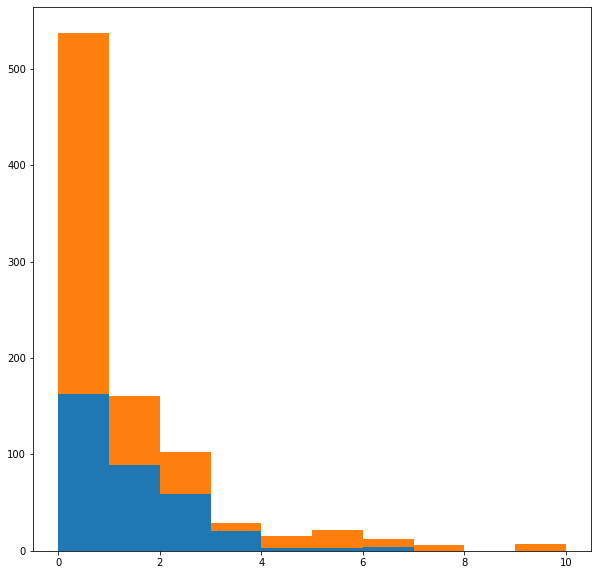

In [568]:
notsurvived, survived = train_df[train_df["Survived"] == 0], train_df[train_df["Survived"] == 1]
b = pp.hist([survived["Family_Size"], notsurvived["Family_Size"]], bins=10, range=(0, 10), stacked=True)
train_df.groupby("Family_Size").agg({'Survived':[np.mean, 'count']})

In [569]:
train_df.groupby("Alone").agg({'Survived':[np.mean, 'count']})

Survived      
           mean count
Alone                
0      0.505650   354
1      0.303538   537

In [570]:
train_df['Embarked'].fillna(train_df['Embarked'].mode()[0],inplace=True)
train_df.groupby("Embarked").agg({'Survived':[np.mean, 'count']})

Survived      
              mean count
Embarked                
C         0.553571   168
Q         0.389610    77
S         0.339009   646

### Feature combinations

In [571]:
train_df.groupby(["Sex", "Pclass"]).agg({'Survived':[np.mean, 'count']})

Survived      
                   mean count
Sex    Pclass                
female 1       0.968085    94
       2       0.921053    76
       3       0.500000   144
male   1       0.368852   122
       2       0.157407   108
       3       0.135447   347

In [572]:
# Lets make feature called: "HighClassWoman"
def addHighClassWoman(row):
    if row["Sex"] == 'female' and row["Pclass"] < 3:
        return 1
    else:
        return 0
train_df["HighClassWoman"] = train_df.apply(lambda row: addHighClassWoman(row), axis=1)

In [573]:
train_df.groupby(["HighClassWoman"]).agg({'Survived':[np.mean, 'count']})

Survived      
                    mean count
HighClassWoman                
0               0.251040   721
1               0.947059   170

In [574]:
train_df.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked,Fare_bin,Title,Age_bin,Family_Size,Alone,HighClassWoman
PassengerId,,,,,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,7.2500,S,1,Mr.,2,1,0,0
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,71.2833,C,2,Mrs.,2,1,0,1
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,7.9250,S,1,Miss.,2,0,1,0
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,53.1000,S,2,Mrs.,2,1,0,1
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,8.0500,S,1,Mr.,2,0,1,0


### Feature encoding and selection

In [575]:
def encodeFeatures(df):
    le = preprocessing.LabelEncoder()

    le.fit(df["Title"])
    df["Title"] = le.transform(df["Title"])

    le.fit(df["Sex"])
    df["Sex"] = le.transform(df["Sex"])

    le.fit(df["Embarked"])
    df["Embarked"] = le.transform(df["Embarked"])

    return df
    
train_df = encodeFeatures(train_df)
    
train_df.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked,Fare_bin,Title,Age_bin,Family_Size,Alone,HighClassWoman
PassengerId,,,,,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",1,22.0,1,0,7.2500,2,1,3,2,1,0,0
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.0,1,0,71.2833,0,2,4,2,1,0,1
3,1,3,"Heikkinen, Miss. Laina",0,26.0,0,0,7.9250,2,1,2,2,0,1,0
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35.0,1,0,53.1000,2,2,4,2,1,0,1
5,0,3,"Allen, Mr. William Henry",1,35.0,0,0,8.0500,2,1,3,2,0,1,0


In [576]:
selected_features = ["Pclass", "Age_bin", "Sex", "Title", "Alone"]

train_labels = train_df["Survived"]
train_df = train_df[selected_features]

train_df.head()

,Pclass,Age_bin,Sex,Title,Alone
PassengerId,,,,,
1,3,2,1,3,0
2,1,2,0,4,0
3,3,2,0,2,1
4,1,2,0,4,0
5,3,2,1,3,1


In [577]:
print("Before:\t{}".format(train_df.shape))

ohe = preprocessing.OneHotEncoder(categories='auto')
ohe.fit(train_df)
train_df = ohe.transform(train_df).toarray()

print("After:\t{}".format(train_df.shape))

Before:	(891, 5)
After:	(891, 16)


In [578]:
train_df

array([[0., 0., 1., ..., 0., 1., 0.],
       [1., 0., 0., ..., 0., 1., 0.],
       [0., 0., 1., ..., 0., 0., 1.],
       ...,
       [0., 0., 1., ..., 0., 1., 0.],
       [1., 0., 0., ..., 0., 0., 1.],
       [0., 0., 1., ..., 0., 0., 1.]])

In [579]:
train_labels.values

array([0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1,
       1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1,
       1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1,
       1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0,
       0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0,
       1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0,
       1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0,
       0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0,
       1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1,

### Spliting the training set, cross validation, parameter optimization

In [580]:
train_len = int(len(train_df) * 0.6)

X_train = train_df[:train_len, :]
Y_train = train_labels.values[:train_len]

X_valid = train_df[train_len:, :]
Y_valid = train_labels.values[train_len:]

len(X_train), len(X_valid)

(534, 357)

In [581]:
X = train_df
y = train_labels.values
kf = KFold(n_splits=50)

models = [
    linear_model.LogisticRegression(solver='liblinear'),
    KNeighborsClassifier(),
    GaussianNB()
]

names = ["LOGREG", "KNN", "GNB"]

results = {}
for name, model in zip(names, models):
    metrics = []
    for train_index, test_index in kf.split(X):
        train_x = np.take(X, train_index, axis=0)
        train_y = np.take(y, train_index, axis=0)

        test_x = np.take(X, test_index, axis=0)
        test_y = np.take(y, test_index, axis=0)

        fit = model.fit(train_x, train_y)
        y_pred = fit.predict(test_x)
        y_pred_proba = fit.predict_proba(test_x)
        
        metrics.append([accuracy_score(test_y, y_pred), roc_auc_score(test_y, y_pred_proba[:, 1])])
    
    results[name] = [np.mean(metrics, axis=0)[0], np.mean(metrics, axis=0)[1]]
    
pd.DataFrame(data=results, index=["Accuracy", "AUC"])

,LOGREG,KNN,GNB
Accuracy,0.812941,0.792484,0.776732
AUC,0.852709,0.830310,0.809221


In [582]:
values = [3, 5, 7, 9, 11, 13, 15, 17, 19]

results = {}
metrics = []

for value in values:
    for train_index, test_index in kf.split(X):
        train_x = np.take(X, train_index, axis=0)
        train_y = np.take(y, train_index, axis=0)

        test_x = np.take(X, test_index, axis=0)
        test_y = np.take(y, test_index, axis=0)

        fit = KNeighborsClassifier(n_neighbors=value).fit(train_x, train_y)
        y_pred = fit.predict(test_x)        
        y_pred_proba = fit.predict_proba(test_x)

        metrics.append([accuracy_score(test_y, y_pred), roc_auc_score(test_y, y_pred_proba[:, 1])])

    results[value] = [np.mean(metrics, axis=0)[0], np.mean(metrics, axis=0)[1]]

pd.DataFrame(data=results, index=["Accuracy", "AUC"])

,3,5,7,9,11,13,15,17,19
Accuracy,0.785752,0.789118,0.792092,0.795245,0.798235,0.799292,0.799748,0.800662,0.801394
AUC,0.821866,0.826088,0.831373,0.836321,0.838527,0.840434,0.842301,0.844260,0.845292


## Testing data preparation

In [583]:
analyzeColumns(test_df)

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
minimum,1.000000,NaN,NaN,0.170000,0.000000,0.000000,NaN,0.000000,NaN,NaN
maximum,3.000000,NaN,NaN,76.000000,8.000000,9.000000,NaN,512.329200,NaN,NaN
mean,2.265550,NaN,NaN,30.272590,0.447368,0.392344,NaN,35.627188,NaN,NaN
stddev,0.841838,NaN,NaN,14.181209,0.896760,0.981429,NaN,55.907576,NaN,NaN
nans,0.000000,0.0,0.0,86.000000,0.000000,0.000000,0.0,1.000000,327.0,0.0
unique,3.000000,418.0,2.0,79.000000,7.000000,8.000000,363.0,169.000000,76.0,3.0


In [584]:
test_df.drop(drop_cols, axis=1, inplace=True)
test_df.head()

,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked
PassengerId,,,,,,,,
892,3,"Kelly, Mr. James",male,34.5,0,0,7.8292,Q
893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,7.0000,S
894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,9.6875,Q
895,3,"Wirz, Mr. Albert",male,27.0,0,0,8.6625,S
896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,12.2875,S


In [585]:
ages

Age      
              mean count
Title                   
Dr.      42.000000     6
Master.   4.574167    36
Miss.    21.773973   146
Mr.      32.368090   398
Mrs.     35.898148   108
Other    42.500000    20

In [586]:
test_df["Title"] = test_df["Name"].apply(lambda x: assignTitle(x.split(" ")))

test_df.head(11)

,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked,Title
PassengerId,,,,,,,,,
892,3,"Kelly, Mr. James",male,34.5,0,0,7.8292,Q,Mr.
893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,7.0000,S,Mrs.
894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,9.6875,Q,Mr.
895,3,"Wirz, Mr. Albert",male,27.0,0,0,8.6625,S,Mr.
896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,12.2875,S,Mrs.
897,3,"Svensson, Mr. Johan Cervin",male,14.0,0,0,9.2250,S,Mr.
898,3,"Connolly, Miss. Kate",female,30.0,0,0,7.6292,Q,Miss.
899,2,"Caldwell, Mr. Albert Francis",male,26.0,1,1,29.0000,S,Mr.
900,3,"Abrahim, Mrs. Joseph (Sophie Halaut Easu)",female,18.0,0,0,7.2292,C,Mrs.


In [587]:
test_df = binAge(test_df)

test_df.head(11)

,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked,Title,Age_bin
PassengerId,,,,,,,,,,
892,3,"Kelly, Mr. James",male,34.5,0,0,7.8292,Q,Mr.,2
893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,7.0000,S,Mrs.,2
894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,9.6875,Q,Mr.,2
895,3,"Wirz, Mr. Albert",male,27.0,0,0,8.6625,S,Mr.,2
896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,12.2875,S,Mrs.,2
897,3,"Svensson, Mr. Johan Cervin",male,14.0,0,0,9.2250,S,Mr.,1
898,3,"Connolly, Miss. Kate",female,30.0,0,0,7.6292,Q,Miss.,2
899,2,"Caldwell, Mr. Albert Francis",male,26.0,1,1,29.0000,S,Mr.,2
900,3,"Abrahim, Mrs. Joseph (Sophie Halaut Easu)",female,18.0,0,0,7.2292,C,Mrs.,1


In [588]:
# Fare (one missing value)
test_df["Fare"] = test_df["Fare"].fillna(test_df["Fare"].mean())
binFare(test_df)

test_df.head()

,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked,Title,Age_bin,Fare_bin
PassengerId,,,,,,,,,,,
892,3,"Kelly, Mr. James",male,34.5,0,0,7.8292,Q,Mr.,2,1
893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,7.0000,S,Mrs.,2,1
894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,9.6875,Q,Mr.,2,1
895,3,"Wirz, Mr. Albert",male,27.0,0,0,8.6625,S,Mr.,2,1
896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,12.2875,S,Mrs.,2,1


In [589]:
addAlone(test_df)

test_df.head()

,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked,Title,Age_bin,Fare_bin,Family_Size,Alone
PassengerId,,,,,,,,,,,,,
892,3,"Kelly, Mr. James",male,34.5,0,0,7.8292,Q,Mr.,2,1,0,1
893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,7.0000,S,Mrs.,2,1,1,0
894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,9.6875,Q,Mr.,2,1,0,1
895,3,"Wirz, Mr. Albert",male,27.0,0,0,8.6625,S,Mr.,2,1,0,1
896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,12.2875,S,Mrs.,2,1,2,0


In [590]:
test_df["HighClassWoman"] = test_df.apply(lambda row: addHighClassWoman(row), axis=1)

test_df.head()

,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked,Title,Age_bin,Fare_bin,Family_Size,Alone,HighClassWoman
PassengerId,,,,,,,,,,,,,,
892,3,"Kelly, Mr. James",male,34.5,0,0,7.8292,Q,Mr.,2,1,0,1,0
893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,7.0000,S,Mrs.,2,1,1,0,0
894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,9.6875,Q,Mr.,2,1,0,1,0
895,3,"Wirz, Mr. Albert",male,27.0,0,0,8.6625,S,Mr.,2,1,0,1,0
896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,12.2875,S,Mrs.,2,1,2,0,0


### Feature encoding and selection

In [591]:
test_df = encodeFeatures(test_df)
    
test_df.head()

,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked,Title,Age_bin,Fare_bin,Family_Size,Alone,HighClassWoman
PassengerId,,,,,,,,,,,,,,
892,3,"Kelly, Mr. James",1,34.5,0,0,7.8292,1,3,2,1,0,1,0
893,3,"Wilkes, Mrs. James (Ellen Needs)",0,47.0,1,0,7.0000,2,4,2,1,1,0,0
894,2,"Myles, Mr. Thomas Francis",1,62.0,0,0,9.6875,1,3,2,1,0,1,0
895,3,"Wirz, Mr. Albert",1,27.0,0,0,8.6625,2,3,2,1,0,1,0
896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",0,22.0,1,1,12.2875,2,4,2,1,2,0,0


In [592]:
test_df = test_df[selected_features]

test_df.head()

,Pclass,Age_bin,Sex,Title,Alone
PassengerId,,,,,
892,3,2,1,3,1
893,3,2,0,4,0
894,2,2,1,3,1
895,3,2,1,3,1
896,3,2,0,4,0


In [593]:
test_ids = test_df.index
print("Before:\t{}".format(test_df.shape))

ohe = preprocessing.OneHotEncoder(categories='auto')
ohe.fit(test_df)
test_df = ohe.transform(test_df).toarray()

print("After:\t{}".format(test_df.shape))

Before:	(418, 5)
After:	(418, 16)


## Final step: learning on training set and predicting on testing set

In [594]:
logreg = linear_model.LogisticRegression(solver='liblinear')
res = logreg.fit(train_df, train_labels).predict(test_df)
res

array([0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0,
       1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1,
       1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1,
       0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1,
       0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,

## Save predictions and submit to Kaggle

In [595]:
results = pd.DataFrame({
    'PassengerId': np.array(test_ids), 
    'Survived':    np.array(res)
    }, 
    columns=['PassengerId', 'Survived']
)
results.to_csv("predictions.csv", index=False)

In [596]:
!kaggle competitions submit titanic -f predictions.csv -m "My first submission"

100%|██████████████████████████████████████| 2.77k/2.77k [00:00<00:00, 18.0kB/s]
Successfully submitted to Titanic: Machine Learning from Disaster

## Ideas

- Feature selection

- Different binning functions? 

- Continuous features instead of binning?

- New feature combinations?

- More parameter tweaking?

- Other ML algorithms?

- We skipped "Ticket" and "Cabin" but we can use them to define groups, which could be a useful feature.